In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import json
from glob import glob
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']  # Ëß£ÂÜ≥‰∏≠ÊñáÊòæÁ§∫ÈóÆÈ¢ò
plt.rcParams['axes.unicode_minus'] = False    # Ëß£ÂÜ≥Ë¥üÂè∑ÊòæÁ§∫ÈóÆÈ¢ò

# 1. Â§ÑÁêÜÊñá‰ª∂

## 1.1 Â§ÑÁêÜiniÊñá‰ª∂

In [7]:
# Êï∞ÊçÆÂ§ÑÁêÜÂáΩÊï∞
def process_screw(num, screw):
    # ÂÆö‰πâÈúÄË¶ÅÊèêÂèñÁöÑÂ≠óÊÆµ
    fields = [
        'FillDataOK', 'FinalTorque', 'FinalAngle', 'jiajinli',
        'MaxAngle', 'MinAngle', 'ScrewNum', 'PostPressForce', 'Result'
    ]
    item = {field: screw.get(field, '') for field in fields}
    
    # Â§ÑÁêÜPointÊï∞ÊçÆ
    point = screw.get('Point', {})
    item['Point_X'] = point.get('X', '')
    item['Point_Y'] = point.get('Y', '')
    
    # Êà™ÂèñÂâç5‰∏™Êï∞ÊçÆÁÇπ
    torque_data = screw.get('TorqueData', {}).get('$values', [])
    # item['TorqueData'] = ', '.join(map(str, torque_data)) if torque_data else ''
    item['TorqueData'] = torque_data
    
    angle_data = screw.get('AngleData', {}).get('$values', [])
    # item['AngleData'] = ', '.join(map(str, angle_data)) if angle_data else ''
    item['AngleData'] = angle_data

    item['ScrewIndex'] = num
    
    return item

def parsefile(file):
    with open(file, 'r', encoding='utf-8') as f:
        content = f.read().strip()

    # ÂéªÈô§ÂèØËÉΩÁöÑÈùûJSONÈÉ®ÂàÜÔºàÂ¶ÇÂ§¥ÈÉ®Ê≥®ÈáäÔºâ
    cleaned_content = ("{" + content.split("{", 1)[-1].rsplit("}", 1)[0] + "}").strip()
    data = json.loads(cleaned_content)

    screw_index = {0: 4, 1: 2, 2: 1, 3: 41}
    # ÊèêÂèñÊï∞ÊçÆ
    rows = []
    for idx, group in enumerate(data['atlasData']['$values'][:4]):
        item = process_screw(screw_index.get(idx), group['$values'][0])
        item['time'] = data['WatchId']
        item['HsgSn'] = data['HsgSn']
        rows.append(item)

    # ÂàõÂª∫DataFrame
    df = pd.DataFrame(rows)
    return df

In [8]:
files = glob("../datas/NPI-LGÈîÅËû∫‰∏ùÂéüÂßãÊï∞ÊçÆ-20250716-0731/*/*.ini")
dfs = []

for file in files:
    dfs.append(parsefile(file))

df = pd.concat(dfs, ignore_index=True)
df.columns = [x.lower() for x in df.columns]
df['time'] = pd.to_datetime(df['time'].str[:12], format='%Y%m%d%H%M%S')

In [9]:
df['row_index'] = df.groupby(['hsgsn'])['hsgsn'].cumcount()
df = df.sort_values(['time', 'row_index'])[[      # , 'jiajinli' 'point_x', 'point_y'
    'hsgsn', 'time', 'screwindex', 'torquedata', 'angledata', 'result', 'filldataok', 'finaltorque', 
    'finalangle', 'maxangle', 'minangle', 'screwnum',
]]

In [9]:
df.to_csv("../datas/NPI-LGÈîÅËû∫‰∏ùÂéüÂßãÊï∞ÊçÆ-20250716-0731/npi_lg_details.csv", index=False)

## 1.2 join tcm datas

In [10]:
tcm_datas = pd.read_csv("../datas/NPIÊï∞ÊçÆÊî∂ÈõÜ/LG-1/tcmdata.csv")
npi_lg_details = pd.read_csv("../datas/NPI-LGÈîÅËû∫‰∏ùÂéüÂßãÊï∞ÊçÆ-20250716-0731/npi_lg_details.csv")

In [11]:
df_use = pd.merge(df, tcm_datas, how="inner", left_on=['hsgsn', 'screwindex'], right_on=['SN', 'screw position'])
# df_use.to_csv("../datas/screw_tcm.csv", index=False)

# 2. ÂàÜÊûê

In [12]:
df_use['recommended_action'].value_counts()

recommended_action
Continue    7506
Rework        11
FA             3
Name: count, dtype: int64

## 2.1 ÁªòÂõæ

In [13]:
print(df_use.columns.tolist())

['hsgsn', 'time', 'screwindex', 'torquedata', 'angledata', 'result', 'filldataok', 'finaltorque', 'finalangle', 'maxangle', 'minangle', 'screwnum', 'DateTime', 'Pass/Fail', 'filename', 'SN', 'screw position', 'screw number', 'failure_clamp', 'failure_slip', 'failure_rehit', 'failure_angle', 'failure_trigger_lost', 'failure_free_spin', 'failure_cross_thread', 'failure_target_torque', 'failure_excess_friction', 'failure_script', 'failure_clamptorque_spec', 'failure_clampangle_spec', 'failure_loaddata', 'target_torque_result', 'clamp_torque_result', 'clamp_angle_max_result', 'clamp_angle_min_result', 'recommended_action', 'angle_start', 'angle_max', 'torque_start', 'torque_max', 'torque_final', 'clamp_torque', 'clamp_angle', 'torque_sit', 'angle_sit', 'max_torque_before_sit', 'angle_at_maxTorque_before_sit', 'angular_work_total', 'angular_work_after_sit', 'angular_work_before_sit', 'clamp_torque_percentage', 'torque_sit_percentage', 'Normalized_integral', 'gradient_mean', 'gradient_stdev'

In [89]:
screw_order = [1, 2, 4, 41]

def validate_data(row):
    """È™åËØÅÊØè‰∏™Ê†∑Êú¨ÁöÑangleÂíåtorqueÊï∞ÊçÆÈïøÂ∫¶ÊòØÂê¶‰∏ÄËá¥"""
    if len(row['angledata']) != len(row['torquedata']):
        print(f"Ë≠¶ÂëäÔºöÊ†∑Êú¨ {row.name} ÁöÑangledataÂíåtorquedataÈïøÂ∫¶‰∏ç‰∏ÄËá¥Ôºà{len(row['angledata'])} vs {len(row['torquedata'])}ÔºâÔºåÂ∑≤Ë∑≥Ëøá")
        return False
    return True

def filter_negative_values(angle_list, torque_list, min_value=0):
    """
    ÂêåÊ≠•ËøáÊª§angleÂíåtorque‰∏≠ÁöÑË¥üÂÄºÊï∞ÊçÆÔºà‰øùÁïô‰∏§ËÄÖÂùá‚â•min_valueÁöÑÁÇπÔºâ
    ËøîÂõûËøáÊª§ÂêéÁöÑ(angle_sublist, torque_sublist)
    """
    # ÁîüÊàêÁ¥¢ÂºïÂàóË°®Ôºå‰ªÖ‰øùÁïô‰∏§ËÄÖÂùá‚â•min_valueÁöÑ‰ΩçÁΩÆ  a <= min_value and
    valid_indices = [
        idx for idx, (a, t) in enumerate(zip(angle_list, torque_list)) 
        if t > min_value
    ]
    # ÊèêÂèñËøáÊª§ÂêéÁöÑÂ≠êÂàóË°®ÔºàËã•Ê≤°ÊúâÊúâÊïàÊï∞ÊçÆËøîÂõûÁ©∫ÂàóË°®Ôºâ
    angle_sub = [angle_list[idx] for idx in valid_indices] if valid_indices else []
    torque_sub = [torque_list[idx] for idx in valid_indices] if valid_indices else []
    return angle_sub, torque_sub

def getValidGroups():
    valid_df = df_use[df_use.apply(validate_data, axis=1)]
    grouped = valid_df.groupby(['recommended_action', 'screwindex'])

    # ==================== ÁªòÂõæÂáÜÂ§á ====================
    valid_groups = [
        (action, s_idx) 
        for action in ['Continue', 'Rework', 'FA']  # ÊåâÊé®ËçêÂä®‰ΩúÂõ∫ÂÆöÈ°∫Â∫è
        for s_idx in screw_order  # ÊåâËá™ÂÆö‰πâËû∫‰∏ùÁ¥¢ÂºïÈ°∫Â∫è
        if (action, s_idx) in grouped.groups
    ]
    return valid_groups, grouped

### 2.1.1 ÂàÜÁ±ªÂØπÊØî

In [82]:
# ==================== ÁªòÂõæÂáΩÊï∞ ====================
def plot_comparison(valid_groups, grouped, screw_order, random_state=2):
    n_groups = len(valid_groups)
    n_rows = (n_groups + 3) // 4  # ÊØèË°åÊúÄÂ§ö4‰∏™ÔºåÂêë‰∏äÂèñÊï¥
    n_cols = min(n_groups, 4)

    # ÂàõÂª∫ÁîªÂ∏ÉÔºàÊÄªÂ∞∫ÂØ∏Ê†πÊçÆÂ≠êÂõæÊï∞ÈáèË∞ÉÊï¥Ôºâ
    total_fig_size = (n_cols * 4, n_rows * 3)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=total_fig_size, constrained_layout=True)
    axes = axes.ravel()  # Â±ïÂπ≥‰∏∫‰∏ÄÁª¥Êï∞ÁªÑÊñπ‰æøÂæ™ÁéØ
    
    screw_colors = plt.cm.get_cmap('tab10', 4)  # ‰ΩøÁî®tab10Ëâ≤Âç°ÔºàÊîØÊåÅ10ÁßçÁ¥¢ÂºïÔºâ
    screw_color_map = {s_idx: screw_colors(i) for i, s_idx in enumerate(screw_order)}
    
    for plot_idx, (action, s_idx) in enumerate(valid_groups):
        ax = axes[plot_idx]
        
        # Â≠êÂõæÊ†áÈ¢òÔºàÂåÖÂê´Êé®ËçêÂä®‰ΩúÂíåËû∫‰∏ùÁ¥¢ÂºïÔºâ
        ax.set_title(f'"{action}" {s_idx}', fontsize=12, pad=10)
        ax.set_xlabel('Angle', fontsize=10)
        ax.set_ylabel('Torque', fontsize=10)
        
        # Ëé∑ÂèñÂΩìÂâçÁªÑÁöÑÂéüÂßãÊï∞ÊçÆ
        group = grouped.get_group((action, s_idx))
        sampled_group = group.sample(n=min(8, len(group)), random_state=random_state) if len(group) > 0 else pd.DataFrame()

        # ÁªòÂà∂ÊØè‰∏™ÈááÊ†∑Ê†∑Êú¨ÁöÑÊõ≤Á∫ø
        for sample_idx, (row_idx, row) in enumerate(sampled_group.iterrows()):
            # ÂéüÂßãÊï∞ÊçÆ
            raw_angle = row['angledata']
            raw_torque = row['torquedata']
            filtered_angle, filtered_torque = filter_negative_values(raw_angle, raw_torque, min_value=0)

            # ÁªòÂà∂Êõ≤Á∫øÔºà‰ΩøÁî®Âõ∫ÂÆöÈ¢úËâ≤Âå∫ÂàÜËû∫‰∏ùÁ¥¢ÂºïÔºåÈÄèÊòéÂ∫¶Âå∫ÂàÜÊ†∑Êú¨Ôºâ, color=screw_color_map[s_idx]
            ax.plot(filtered_angle, filtered_torque, alpha=0.8 - (sample_idx * 0.1), linewidth=1.2, marker='', linestyle='-', label=row['hsgsn'])
        # Ê∑ªÂä†Âõæ‰æãÔºà‰ªÖÊòæÁ§∫ÂΩìÂâçÂ≠êÂõæÁöÑÊ†∑Êú¨Ôºâ
        ax.legend(loc='best', fontsize=8)    # frameon=True, 
        ax.grid(True, linestyle='--', alpha=0.4)

    for idx in range(len(valid_groups), len(axes)):
        axes[idx].axis('off')
    # Ê∑ªÂä†ÊÄªÊ†áÈ¢ò
    fig.suptitle('Torque vs Angle Comparison by Recommended Action', fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()

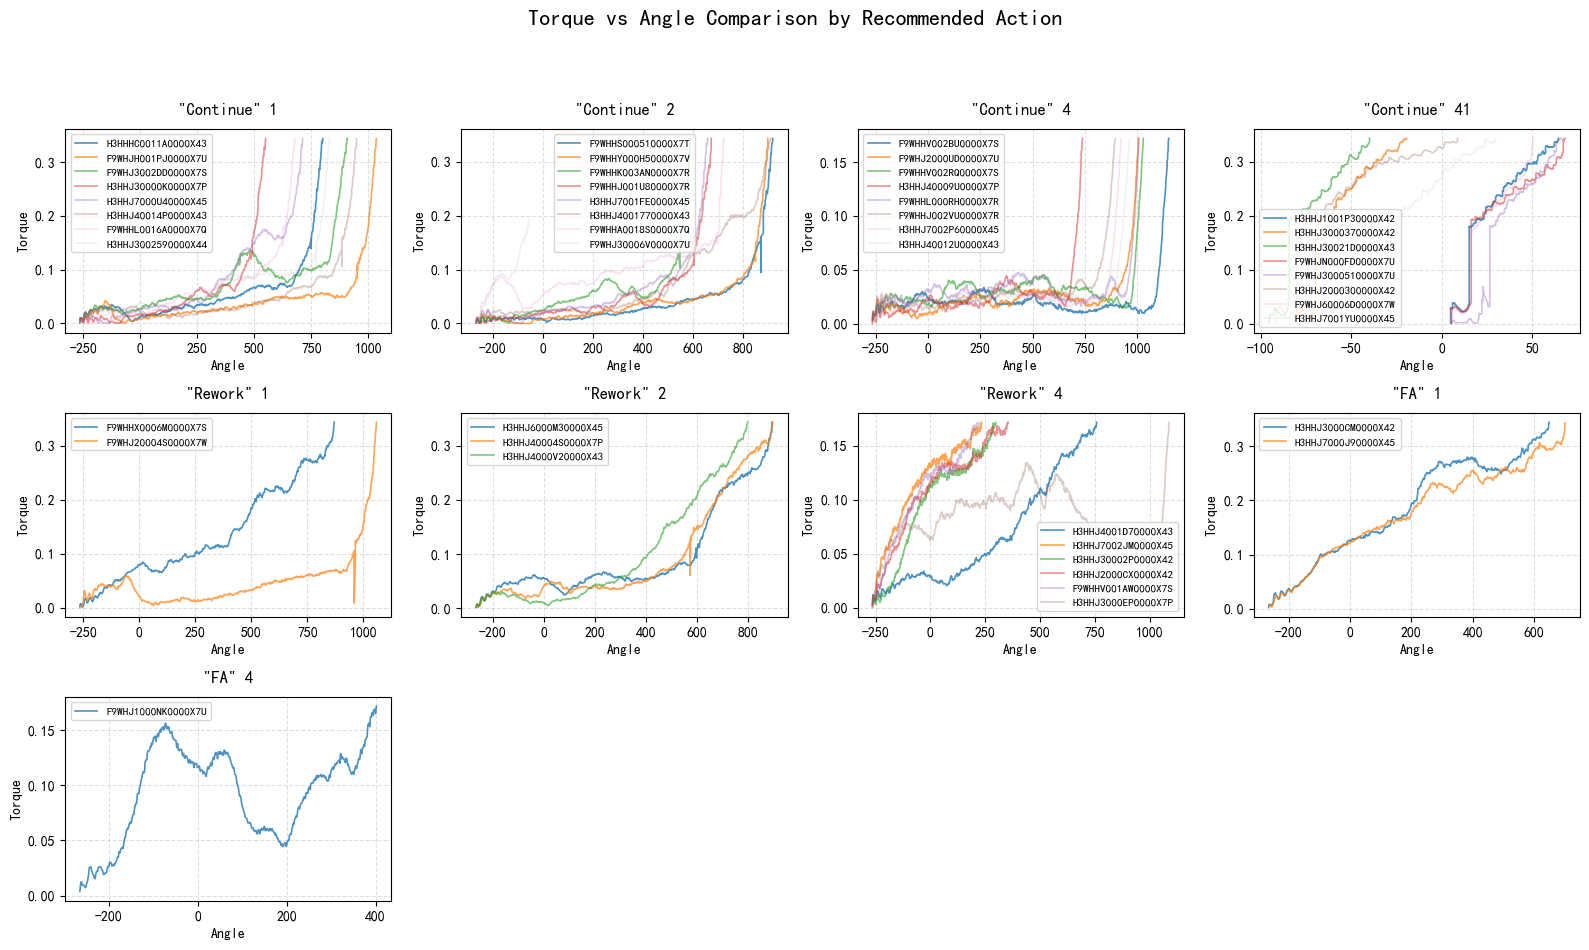

In [90]:
valid_groups, grouped = getValidGroups()
np.random.seed(1)
plot_comparison(valid_groups, grouped, screw_order, random_state=1)

## 2.2 fft

[('Continue', 1), ('Continue', 2), ('Continue', 4), ('Continue', 41), ('Rework', 1), ('Rework', 2), ('Rework', 4), ('FA', 1), ('FA', 4)]


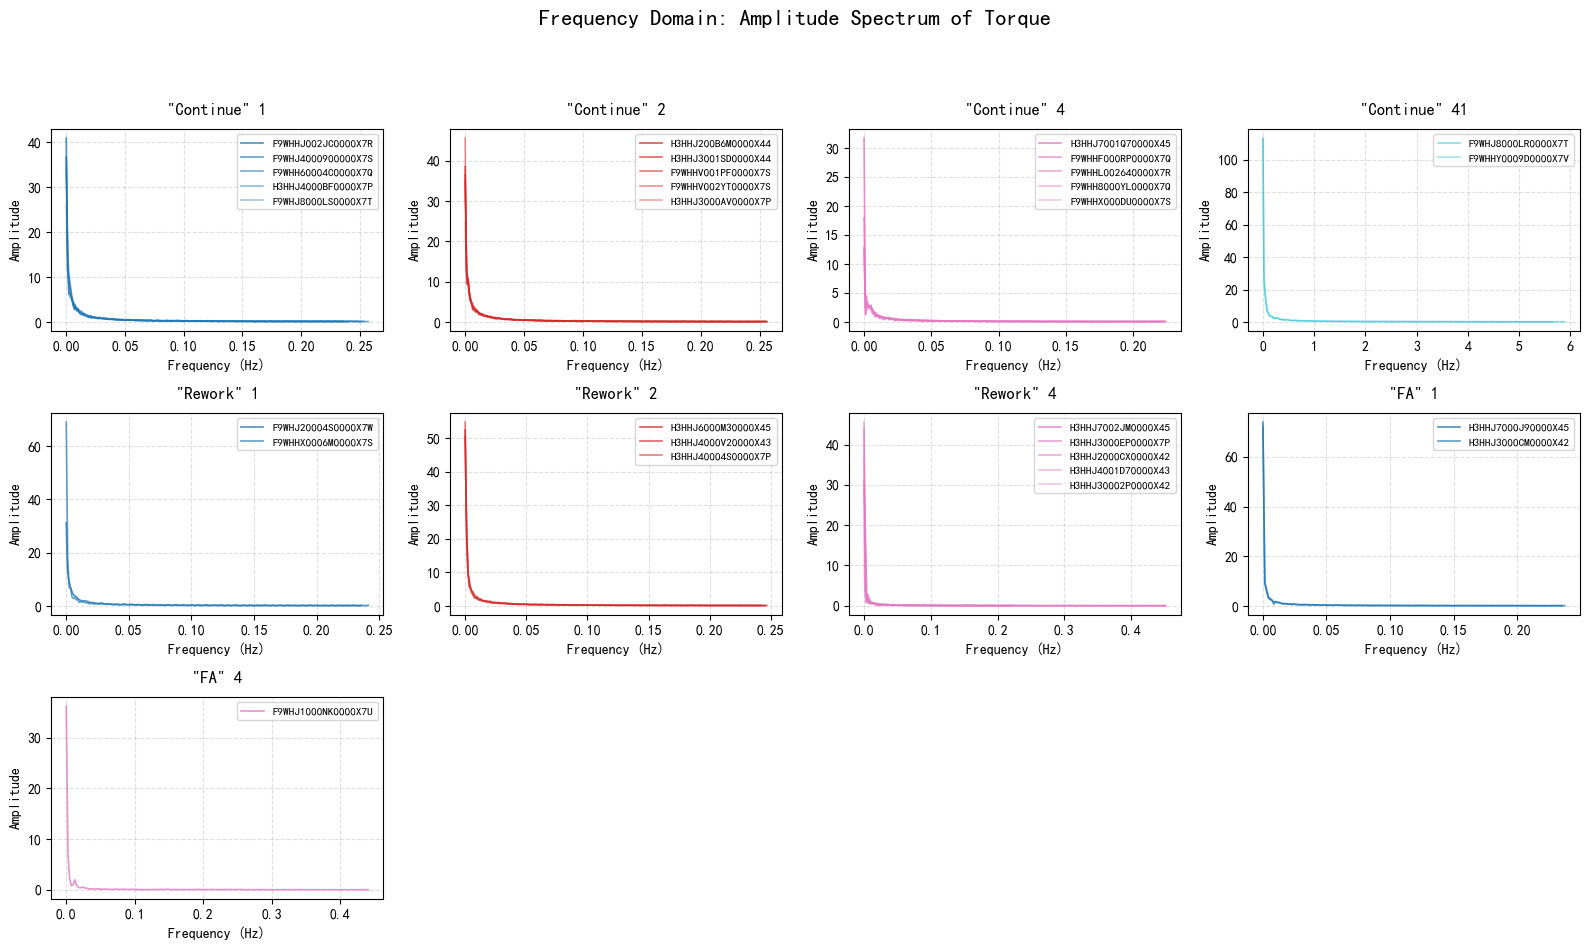

In [ ]:
from scipy.fft import fft, fftfreq

def plot_comparison_freq(valid_groups, grouped, screw_order, random_state=2):
    n_groups = len(valid_groups)
    n_rows = (n_groups + 3) // 4  # ÊØèË°åÊúÄÂ§ö4‰∏™ÔºåÂêë‰∏äÂèñÊï¥
    n_cols = min(n_groups, 4)

    # ÂàõÂª∫ÁîªÂ∏ÉÔºàÊÄªÂ∞∫ÂØ∏Ê†πÊçÆÂ≠êÂõæÊï∞ÈáèË∞ÉÊï¥Ôºâ
    total_fig_size = (n_cols * 4, n_rows * 3)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=total_fig_size, constrained_layout=True)
    axes = axes.ravel()  # Â±ïÂπ≥‰∏∫‰∏ÄÁª¥Êï∞ÁªÑÊñπ‰æøÂæ™ÁéØ
    
    screw_colors = plt.cm.get_cmap('tab10', 4)  # ‰ΩøÁî®tab10Ëâ≤Âç°ÔºàÊîØÊåÅ10ÁßçÁ¥¢ÂºïÔºâ
    screw_color_map = {s_idx: screw_colors(i) for i, s_idx in enumerate(screw_order)}
    
    for plot_idx, (action, s_idx) in enumerate(valid_groups):
        ax = axes[plot_idx]
        
        # Â≠êÂõæÊ†áÈ¢òÔºàÂåÖÂê´Êé®ËçêÂä®‰ΩúÂíåËû∫‰∏ùÁ¥¢ÂºïÔºâ
        ax.set_title(f'"{action}" {s_idx}', fontsize=12, pad=10)
        ax.set_xlabel('Frequency (Hz)', fontsize=10)
        ax.set_ylabel('Amplitude', fontsize=10)
        
        # Ëé∑ÂèñÂΩìÂâçÁªÑÁöÑÂéüÂßãÊï∞ÊçÆ
        group = grouped.get_group((action, s_idx))
        sampled_group = group.sample(n=min(5, len(group)), random_state=random_state) if len(group) > 0 else pd.DataFrame()

        # ÁªòÂà∂ÊØè‰∏™ÈááÊ†∑Ê†∑Êú¨ÁöÑÈ¢ëÂüüÊõ≤Á∫ø
        for sample_idx, (row_idx, row) in enumerate(sampled_group.iterrows()):
            angle_data = row['angledata']
            torque_data = row['torquedata']
            
            # ËøáÊª§ÊéâË¥üÂÄºÔºàÂ¶ÇÊûúÊÇ®ÊúâÊ≠§ÈúÄÊ±ÇÔºâ
            filtered_angle, filtered_torque = filter_negative_values(angle_data, torque_data, min_value=0)

            # Âè™ÂèñÊâ≠Áü©‰ø°Âè∑ÂÅöÈ¢ëË∞±ÂàÜÊûê
            signal = filtered_torque

            # ÊâßË°åFFT
            n = len(signal)
            if n == 0:
                continue  # Ë∑≥ËøáÁ©∫‰ø°Âè∑

            yf = fft(signal)
            xf = fftfreq(n, d=np.mean(np.diff(filtered_angle)))  # ÂÅáËÆæangledataÊòØÊó∂Èó¥ÊàñËÄÖ‰ΩçÁΩÆÁöÑÁ≠âÈó¥ÈöîÈááÊ†∑ÔºåÁî®ÂÖ∂Â∑ÆÂÄº‰Ωú‰∏∫ÈááÊ†∑Èó¥Èöî‰º∞ËÆ°

            # ÂèñÊ≠£È¢ëÁéáÈÉ®ÂàÜÔºåÂπ∂ÊéíÂ∫è
            positive_freq_mask = xf >= 0
            xf_pos = xf[positive_freq_mask]
            yf_pos = np.abs(yf[positive_freq_mask])  # ÂèñÂπÖÂÄºÔºàÊÇ®‰πüÂèØ‰ª•Áî® np.square(yf[positive_freq_mask]) Ë°®Á§∫ÂäüÁéáÔºâ

            # ÂèØÈÄâÔºöÈôêÂà∂ÊòæÁ§∫ÁöÑÈ¢ëÁéáËåÉÂõ¥ÔºåÊØîÂ¶ÇÂè™ÊòæÁ§∫ÂâçËã•Âπ≤HzÔºåÊàñÂØπÈ´òÈ¢ëÂÅöÊà™Êñ≠
            max_freq_to_show = 50  # ÊÇ®ÂèØ‰ª•Ê†πÊçÆÂÆûÈôÖÊÉÖÂÜµË∞ÉÊï¥ÔºåÊØîÂ¶Ç 10, 50, 100 Hz
            freq_mask = xf_pos <= max_freq_to_show
            xf_display = xf_pos[freq_mask]
            yf_display = yf_pos[freq_mask]

            # ÁªòÂà∂È¢ëÂüüÂπÖÂÄºË∞±
            color = screw_color_map[s_idx]
            alpha = 0.8 - (sample_idx * 0.1)
            ax.plot(xf_display, yf_display, alpha=alpha, linewidth=1.2, marker='', linestyle='-', 
                    color=color, label=f"{row.get('hsgsn', f'Sample {sample_idx}')}")
        
        # Ê∑ªÂä†Âõæ‰æãÔºà‰ªÖÊòæÁ§∫ÂΩìÂâçÂ≠êÂõæÁöÑÊ†∑Êú¨Ôºâ
        ax.legend(loc='best', fontsize=8)
        ax.grid(True, linestyle='--', alpha=0.4)

    # ÈöêËóèÂ§ö‰ΩôÁöÑÂ≠êÂõæ
    for idx in range(len(valid_groups), len(axes)):
        axes[idx].axis('off')
    
    # Ê∑ªÂä†ÊÄªÊ†áÈ¢ò
    fig.suptitle('Frequency Domain: Amplitude Spectrum of Torque', fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()

In [ ]:
valid_groups, grouped = getValidGroups()
plot_comparison_freq(valid_groups, grouped, screw_order, random_state=np.random.randint(1, 10000))

## 2.3 PSD

In [36]:
from scipy.signal import welch

def plot_comparison_psd(valid_groups, grouped, screw_order, random_state=2):
    n_groups = len(valid_groups)
    n_rows = (n_groups + 3) // 4  # ÊØèË°åÊúÄÂ§ö4‰∏™ÔºåÂêë‰∏äÂèñÊï¥
    n_cols = min(n_groups, 4)

    # ÂàõÂª∫ÁîªÂ∏É
    total_fig_size = (n_cols * 4, n_rows * 3)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=total_fig_size, constrained_layout=True)
    axes = axes.ravel()  # Â±ïÂπ≥‰∏∫‰∏ÄÁª¥Êï∞ÁªÑÊñπ‰æøÂæ™ÁéØ
    
    screw_colors = plt.cm.get_cmap('tab10', 4)  # ‰ΩøÁî®tab10Ëâ≤Âç°
    screw_color_map = {s_idx: screw_colors(i) for i, s_idx in enumerate(screw_order)}
    
    for plot_idx, (action, s_idx) in enumerate(valid_groups):
        ax = axes[plot_idx]
        
        # Â≠êÂõæÊ†áÈ¢ò
        ax.set_title(f'"{action}" {s_idx}', fontsize=12, pad=10)
        ax.set_xlabel('Frequency (Hz)', fontsize=10)
        ax.set_ylabel('Power Spectral Density', fontsize=10)
        
        # Ëé∑ÂèñÂΩìÂâçÁªÑÊï∞ÊçÆ
        group = grouped.get_group((action, s_idx))
        sampled_group = group.sample(n=min(5, len(group)), random_state=random_state) if len(group) > 0 else pd.DataFrame()

        for sample_idx, (row_idx, row) in enumerate(sampled_group.iterrows()):
            torque_signal = row['torquedata']
            angle_signal = row['angledata']

            # ËøáÊª§Ë¥üÂÄºÔºàÂ¶ÇÊûúÊÇ®ÁöÑÊï∞ÊçÆÈúÄË¶ÅÔºâ
            filtered_angle, filtered_torque = filter_negative_values(angle_signal, torque_signal, min_value=0)

            signal = filtered_torque  # Âè™ÂàÜÊûêÊâ≠Áü©‰ø°Âè∑

            if len(signal) < 4:
                continue  # WelchÊñπÊ≥ïËá≥Â∞ëÈúÄË¶Å‰∏ÄÂÆöÈïøÂ∫¶ÔºåÂ§™Áü≠Êó†Ê≥ïÂàÜÊÆµ

            # ‰ΩøÁî® scipy.signal.welch ËÆ°ÁÆóÂäüÁéáË∞±ÂØÜÂ∫¶
            # fs: ÈááÊ†∑È¢ëÁéáÔºåÂçï‰Ωç Hz„ÄÇÂ¶ÇÊûúÊÇ®Áü•ÈÅìÁúüÂÆûÈááÊ†∑ÁéáÔºåËØ∑ÊõøÊç¢ÔºÅÔºÅÔºÅ
            # ‰∏ãÈù¢ÂÅáËÆæ angle_signal ÊòØ‚Äú‰ΩçÁΩÆ/ËßíÂ∫¶‚ÄùÔºåÂπ∂‰∏îÊòØÂùáÂåÄÈááÊ†∑ÔºåÁî®ÂÖ∂Â∑ÆÂÄº‰º∞ËÆ°ÈááÊ†∑Èó¥Èöî
            angle_diff_mean = np.mean(np.diff(filtered_angle))
            if angle_diff_mean <= 0:
                continue  # ÈÅøÂÖçÈô§Èõ∂ÊàñÂèçÂêëÈááÊ†∑
            fs = 1.0 / angle_diff_mean  # ‰º∞ÁÆóÈááÊ†∑È¢ëÁéá = 1 / ÈááÊ†∑Èó¥ÈöîÔºàÂçï‰Ωç HzÔºâ

            # Welch ÊñπÊ≥ïÂèÇÊï∞
            f_psd, psd = welch(signal, fs=fs,
                window='hann',      # Âä†Á™óÂáèÂ∞ëÊ≥ÑÊºè
                nperseg=128,        # ÊØèÊÆµÈïøÂ∫¶ÔºåÂèØË∞ÉÊï¥ÔºåÂ¶Ç 128, 256, 512
                noverlap=None,      # ÈªòËÆ§‰∏∫ nperseg // 2
                scaling='density'   # 'density': Âçï‰Ωç (unit^2)/HzÔºõ'spectrum': (unit^2)
            )

            # Âè™ÂèñÊ≠£È¢ëÁéáÈÉ®ÂàÜ
            pos_freq_mask = f_psd >= 0
            f_psd_pos = f_psd[pos_freq_mask]
            psd_pos = psd[pos_freq_mask]

            # ÂèØÈÄâÔºöÈôêÂà∂ÊòæÁ§∫ÁöÑÈ¢ëÁéáËåÉÂõ¥ÔºåÊØîÂ¶Ç 0 ~ 50 Hz
            max_freq_to_show = 50
            freq_mask = f_psd_pos <= max_freq_to_show
            f_display = f_psd_pos[freq_mask]
            psd_display = psd_pos[freq_mask]

            # ÁªòÂà∂ PSD Êõ≤Á∫ø
            color = screw_color_map[s_idx]
            alpha = 0.8 - (sample_idx * 0.1)
            label_text = f"{row.get('hsgsn', f'Sample {sample_idx}')}"
            ax.plot(f_display, psd_display, alpha=alpha, linewidth=1.0, linestyle='-', label=label_text)    # , color=color

        # Âõæ‰æã‰∏éÁΩëÊ†º
        ax.legend(loc='best', fontsize=8)
        ax.grid(True, linestyle='--', alpha=0.4)

    # ÈöêËóèÂ§ö‰ΩôÁöÑÂ≠êÂõæ
    for idx in range(len(valid_groups), len(axes)):
        axes[idx].axis('off')
    
    # ÊÄªÊ†áÈ¢ò
    fig.suptitle('Frequency Domain: Power Spectral Density of Torque Signals', fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()

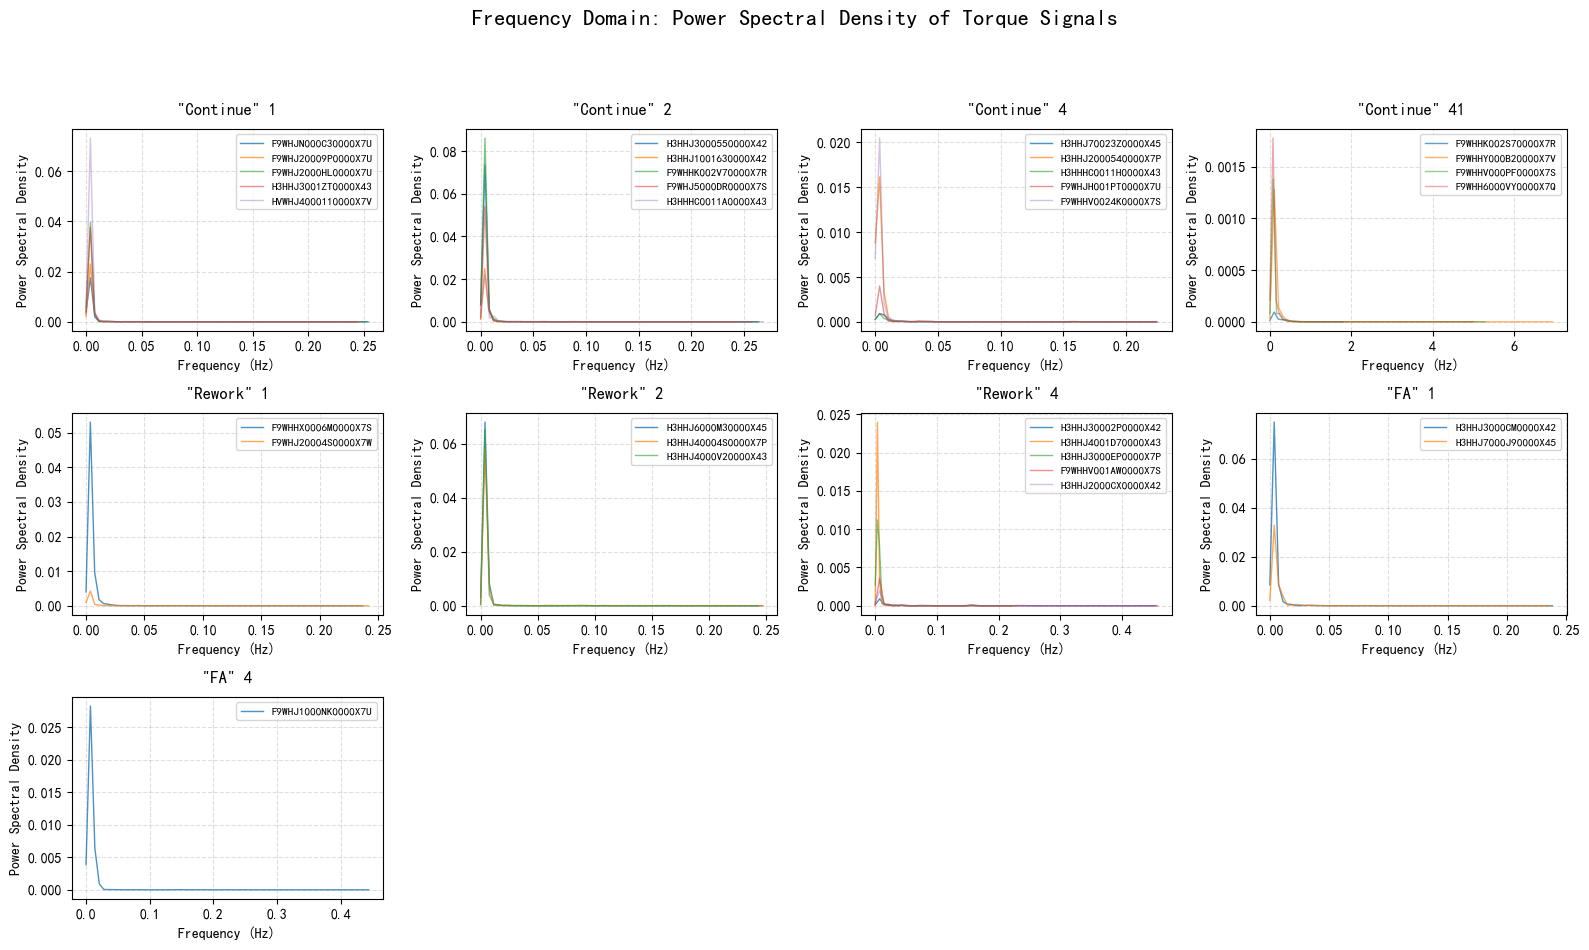

In [44]:
valid_groups, grouped = getValidGroups()
np.random.seed(1)
plot_comparison_psd(valid_groups, grouped, screw_order, random_state=11)

## 2.4 ÂÖ∂‰ªñÁâπÂæÅ

In [68]:
from scipy import stats
from scipy.fft import fft

def extract_basic_stats(angle, torque):
    """Âü∫Á°ÄÁªüËÆ°ÁâπÂæÅÔºöÂùáÂÄº„ÄÅÊñπÂ∑Æ„ÄÅÊúÄÂ§ßÂÄº„ÄÅÊúÄÂ∞èÂÄº„ÄÅÂàÜ‰ΩçÊï∞Á≠â"""
    stats_dict = {
        'torque_mean': np.mean(torque),
        'torque_std': np.std(torque),
        'torque_max': np.max(torque),
        'torque_min': np.min(torque),
        'torque_median': np.median(torque),
        'torque_q1': np.percentile(torque, 25),
        'torque_q3': np.percentile(torque, 75),
        'angle_mean': np.mean(angle),
        'angle_max': np.max(angle),
        'angle_min': np.min(angle),
    }
    return stats_dict

def extract_trend_features(angle, torque):
    """Ë∂ãÂäøÁâπÂæÅÔºöÁ∫øÊÄßÂõûÂΩíÊñúÁéáÔºàÊï¥‰Ωì‰∏äÂçá/‰∏ãÈôçË∂ãÂäøÔºâ„ÄÅÂ§öÈ°πÂºèÊãüÂêàÁ≥ªÊï∞Á≠â"""
    # Á∫øÊÄßÂõûÂΩíÊñúÁéá
    x = np.array(angle).reshape(-1, 1)
    y = np.array(torque).reshape(-1, 1)
    model = stats.linregress(x.flatten(), y.flatten())
    trend_dict = {
        'torque_slope': model.slope,
        'torque_intercept': model.intercept,
        'torque_rvalue': model.rvalue,   # Áõ∏ÂÖ≥Á≥ªÊï∞
        'torque_pvalue': model.pvalue,
    }
    return trend_dict

def extract_shape_features(angle, torque):
    """Êõ≤Á∫øÂΩ¢Áä∂ÁâπÂæÅÔºöÊ≥¢Âä®Á®ãÂ∫¶„ÄÅÂ≥∞ÂÄº/Ë∞∑ÂÄºÊï∞Èáè„ÄÅÊãêÁÇπÊ£ÄÊµãÁ≠â"""
    shape_dict = {}
    
    # ‰∏ÄÈò∂Â∑ÆÂàÜÔºàÊâ≠Áü©ÂèòÂåñÁéáÔºâ
    diff_torque = np.diff(torque)
    shape_dict['torque_diff_mean'] = np.mean(diff_torque)
    shape_dict['torque_diff_std'] = np.std(diff_torque)
    
    # ‰∫åÈò∂Â∑ÆÂàÜÔºàÂèòÂåñÁéáÁöÑÈÄüÁéáÔºâ
    diff2_torque = np.diff(diff_torque)
    shape_dict['torque_diff2_mean'] = np.mean(diff2_torque)
    shape_dict['torque_diff2_std'] = np.std(diff2_torque)
    
    # Â≥∞ÂÄº/Ë∞∑ÂÄºÊï∞ÈáèÔºàÁÆÄÂçïÈòàÂÄºÊ≥ïÔºåÂèØÊ†πÊçÆÂÆûÈôÖË∞ÉÊï¥Ôºâ
    peaks = []
    valleys = []
    for i in range(1, len(torque)-1):
        if torque[i] > torque[i-1] and torque[i] > torque[i+1]:
            peaks.append(torque[i])
        elif torque[i] < torque[i-1] and torque[i] < torque[i+1]:
            valleys.append(torque[i])
    shape_dict['peak_count'] = len(peaks)
    shape_dict['valley_count'] = len(valleys)
    
    # Êâ≠Áü©ÁöÑÊúÄÂ§ßÂèòÂåñÂπÖÂ∫¶Ôºà‰ªéÊúÄÂ∞èÂà∞ÊúÄÂ§ßÁöÑÂ∑ÆÂÄºÔºâ
    shape_dict['torque_range'] = np.max(torque) - np.min(torque)
    
    return shape_dict

def extract_window_features(angle, torque, window_size=100):
    """Âü∫‰∫éÁ™óÂè£ÁöÑÂ±ÄÈÉ®ÁâπÂæÅÔºöÊääangleÂàáÊàêËã•Âπ≤Á™óÂè£ÔºåÂú®ÊØè‰∏™Á™óÂè£ÂÜÖËÆ°ÁÆóÁªüËÆ°Èáè"""
    window_features = {}
    n_windows = len(angle) // window_size
    if n_windows == 0:
        n_windows = 1  # Ëã•Â§™Áü≠ÔºåÂ∞±Âè™ÁÆó‰∏Ä‰∏™Á™óÂè£
    
    for i in range(n_windows):
        start = i * window_size
        end = (i+1) * window_size if (i+1)*window_size < len(angle) else len(angle)
        win_angle = angle[start:end]
        win_torque = torque[start:end]
        
        # Á™óÂè£ÂÜÖÁöÑÂü∫Á°ÄÁªüËÆ°
        win_stats = extract_basic_stats(win_angle, win_torque)
        for k, v in win_stats.items():
            window_features[f'win{i}_{k}'] = v
    
    return window_features

def extract_fft_features(angle, torque, n_components=5):
    # Â¶ÇÊûú torque Â∫èÂàóÂ§™Áü≠ÔºåÊØîÂ¶ÇÈïøÂ∫¶Â∞è‰∫é 4ÔºåÈÇ£‰πà FFT Âá†‰πéÊ≤°ÊúâÊÑè‰πâÔºåÁõ¥Êé•ËøîÂõû nan
    if len(torque) < 4:
        return {
            'fft_energy_1': np.nan,
            'fft_energy_2': np.nan,
            'fft_energy_3': np.nan,
            'fft_energy_4': np.nan,
            'fft_energy_5': np.nan,
        }

    yf = fft(torque)
    xf = np.fft.fftfreq(len(torque), d=np.mean(np.diff(angle)))  # È¢ëÁéáËΩ¥

    # Âè™‰øùÁïôÊ≠£È¢ëÁéáÈÉ®ÂàÜÔºöÂéªÊéâÁõ¥ÊµÅ (idx=0) ÂíåË¥üÈ¢ëÁéá
    # Ê≠£È¢ëÁéáÂØπÂ∫îÁöÑÁ¥¢ÂºïÈÄöÂ∏∏ÊòØ idx > 0 ‰∏î idx < len(xf)/2
    positive_freq_mask = (xf > 0)
    xf_pos = xf[positive_freq_mask]
    yf_pos = np.abs(yf[positive_freq_mask])

    if len(xf_pos) == 0:
        # Â¶ÇÊûúÊ≤°ÊúâÊ≠£È¢ëÁéáÂàÜÈáèÔºå‰πüËøîÂõû nan
        return {
            'fft_energy_1': np.nan,
            'fft_energy_2': np.nan,
            'fft_energy_3': np.nan,
            'fft_energy_4': np.nan,
            'fft_energy_5': np.nan,
        }

    # ËÆ°ÁÆóËÉΩÈáèÂπ∂ÂΩí‰∏ÄÂåñ
    total_energy = np.sum(yf_pos**2)
    if total_energy == 0:
        total_energy = 1e-8
    yf_pos_norm = yf_pos / np.sqrt(total_energy)

    # ÂèñÂâç n_components ‰∏™È¢ëÁéáÂàÜÈáèÁöÑËÉΩÈáè
    n_take = min(n_components, len(yf_pos_norm))  # ÈÅøÂÖçË∂äÁïå
    fft_features = {}
    for i in range(n_take):
        fft_features[f'fft_energy_{i+1}'] = yf_pos_norm[i] ** 2

    # Â¶ÇÊûú n_components > ÂÆûÈôÖÊúâÁöÑÂàÜÈáèÊï∞ÔºåÂâ©‰∏ãÁöÑÈîÆ‰πüËøîÂõû nanÔºàÂèØÈÄâÔºâ
    for i in range(n_take, n_components):
        fft_features[f'fft_energy_{i+1}'] = np.nan

    return fft_features

In [72]:
def extract_features(row):
    raw_angle = row['angledata']
    raw_torque = row['torquedata']
    angle, torque = filter_negative_values(raw_angle, raw_torque, min_value=0)
    if len(angle) == 0 or len(torque) == 0:
        # Â¶ÇÊûú angle Êàñ torque ÊòØÁ©∫ÂàóË°®ÔºåÂàôËøîÂõû‰∏Ä‰∏™ÂÖ®‰∏∫ np.nan ÁöÑÁâπÂæÅÂ≠óÂÖ∏ÔºàÊàñÂ°´ÂÖÖÈªòËÆ§ÂÄºÔºâ
        # ËøôÈáåÊàë‰ª¨ËøîÂõû‰∏Ä‰∏™Â§ßÈÉ®ÂàÜ‰∏∫ np.nan ÁöÑÂ≠óÂÖ∏ÔºåÂêéÁª≠‰Ω†ÂèØ‰ª•ÈÄâÊã©Â¶Ç‰ΩïÂ§ÑÁêÜËøô‰∫õÊ†∑Êú¨
        return {
            'torque_mean': np.nan,
            'torque_std': np.nan,
            'torque_max': np.nan,
            'torque_min': np.nan,
            'torque_median': np.nan,
            'torque_q1': np.nan,
            'torque_q3': np.nan,
            'angle_mean': np.nan,
            'angle_max': np.nan,
            'angle_min': np.nan,
            'torque_slope': np.nan,
            'torque_intercept': np.nan,
            'torque_rvalue': np.nan,
            'torque_pvalue': np.nan,
            'torque_diff_mean': np.nan,
            'torque_diff_std': np.nan,
            'torque_diff2_mean': np.nan,
            'torque_diff2_std': np.nan,
            'peak_count': np.nan,
            'valley_count': np.nan,
            'torque_range': np.nan,
            # ÂÖ∂ÂÆÉÁ™óÂè£ÊàñÂÇÖÈáåÂè∂ÁâπÂæÅ‰πüËøîÂõû nan
            'win0_torque_mean': np.nan,
            'fft_energy_1': np.nan,
            'fft_energy_2': np.nan,
            'fft_energy_3': np.nan,
            'fft_energy_4': np.nan,
            'fft_energy_5': np.nan,
            'loc': row['screwindex'],  # ‰ΩçÁΩÆËøòÊòØÂèØ‰ª•‰øùÁïô
        }
    # Âü∫Á°ÄÁªüËÆ°
    basic_stats = extract_basic_stats(angle, torque)
    # Ë∂ãÂäøÁâπÂæÅ
    trend_features = extract_trend_features(angle, torque)
    # ÂΩ¢Áä∂ÁâπÂæÅ
    shape_features = extract_shape_features(angle, torque)
    # Á™óÂè£ÁâπÂæÅÔºàÂèØÊ†πÊçÆÊï∞ÊçÆÈïøÂ∫¶Ë∞ÉÊï¥window_sizeÔºâ
    # window_features = extract_window_features(angle, torque, window_size=20)
    # ÂÇÖÈáåÂè∂ÁâπÂæÅÔºàÂèØÊ†πÊçÆÈúÄË¶ÅË∞ÉÊï¥n_componentsÔºâ
    fft_features = extract_fft_features(angle, torque, n_components=5)
    # ‰ΩçÁΩÆÁâπÂæÅÔºàÁõ¥Êé•Êääposition‰Ωú‰∏∫ÁâπÂæÅÔºâ
    position_feature = {'loc': row['screwindex']}
    
    # ÂêàÂπ∂ÊâÄÊúâÁâπÂæÅ
    all_features = {**basic_stats, **trend_features, **shape_features, **fft_features, **position_feature} #, **window_features
    return all_features

In [73]:
# 1. ÈÄêË°åÊèêÂèñÁâπÂæÅÔºåÂæóÂà∞Â≠óÂÖ∏ÂàóË°®
features_list = df_use.apply(extract_features, axis=1).tolist()

# 2. ËΩ¨ÊàêDataFrame
features_df = pd.DataFrame(features_list)

In [76]:
# 3. Ê≠§Êó∂features_df‰∏≠ÂåÖÂê´‰∫ÜÊâÄÊúâÁöÑÊ†áÈáèÁâπÂæÅÔºålabelÂíåposition‰πüÂèØ‰ª•joinÂõûÊù•ÔºàÂ¶ÇÊûúÈúÄË¶ÅÔºâ
#    ‰∏ãÈù¢Á§∫‰æãÔºöÊääÂéüdf_useÁöÑlabelÂíåposition‰πümergeËøõÊù•
final_df = pd.concat([df_use[['hsgsn', 'time', 'recommended_action']], features_df], axis=1)
final_df

hsgsn                time recommended_action  torque_mean  \
0     F9W007140220000X7U 2025-07-16 08:04:08           Continue     0.040657   
1     F9W007140220000X7U 2025-07-16 08:04:08           Continue     0.061405   
2     F9W007140220000X7U 2025-07-16 08:04:08           Continue     0.067539   
3     F9W007140220000X7U 2025-07-16 08:04:08           Continue          NaN   
4     F9W007538030000X7U 2025-07-16 08:04:09           Continue     0.043297   
...                  ...                 ...                ...          ...   
7515  HVWHK0000090000XQ7 2025-07-31 19:05:04           Continue          NaN   
7516  HVWHK00000F0000XQ7 2025-07-31 20:00:00           Continue     0.039311   
7517  HVWHK00000F0000XQ7 2025-07-31 20:00:00           Continue     0.103000   
7518  HVWHK00000F0000XQ7 2025-07-31 20:00:00           Continue     0.079055   
7519  HVWHK00000F0000XQ7 2025-07-31 20:00:00           Continue     0.202466   

      torque_std  torque_max  torque_min  torque_median  torque_q1  torque_q3  \
0       0.024250     0.17200     0.00900       0.042850   0.028750   0.045100   
1       0.074646     0.34350     0.00470       0.036350   0.018000   0.055900   
2       0.063539     0.34325     0.01630       0.047150   0.024962   0.083850   
3            NaN         NaN         NaN            NaN        NaN        NaN   
4       0.020433     0.17160     0.01165       0.043250   0.034650   0.045450   
...          ...         ...         ...            ...        ...        ...   
7515         NaN         NaN         NaN            NaN        NaN        NaN   
7516    0.025902     0.17160     0.02010       0.032875   0.028488   0.038463   
7517    0.074479     0.34460     0.01815       0.082250   0.043100   0.144575   
7518    0.076663     0.34365     0.01290       0.044425   0.038288   0.074400   
7519    0.099066     0.34330     0.00220       0.218125   0.147763   0.282888   

      ...  peak_count  valley_count  torque_range  fft_energy_1  fft_energy_2  \
0     ...       107.0         109.0       0.16300      0.130204      0.134029   
1     ...        97.0         100.0       0.33880      0.343274      0.223267   
2     ...       136.0         139.0       0.32695      0.376469      0.177685   
3     ...         NaN           NaN           NaN           NaN           NaN   
4     ...       102.0         107.0       0.15995      0.020006      0.073009   
...   ...         ...           ...           ...           ...           ...   
7515  ...         NaN           NaN           NaN           NaN           NaN   
7516  ...        83.0          86.0       0.15150      0.100282      0.179299   
7517  ...       103.0         102.0       0.32645      0.506109      0.073699   
7518  ...        66.0          68.0       0.33075      0.433889      0.230226   
7519  ...        19.0          25.0       0.34110      0.551964      0.211098   

      fft_energy_3  fft_energy_4  fft_energy_5  loc  win0_torque_mean  
0         0.101941      0.108233      0.089391    4               NaN  
1         0.125769      0.066712      0.048196    2               NaN  
2         0.096210      0.064589      0.052658    1               NaN  
3              NaN           NaN           NaN   41               NaN  
4         0.170126      0.117649      0.069188    4               NaN  
...            ...           ...           ...  ...               ...  
7515           NaN           NaN           NaN   41               NaN  
7516      0.145255      0.136428      0.107139    4               NaN  
7517      0.127718      0.071059      0.041711    2               NaN  
7518      0.097794      0.061480      0.025827    1               NaN  
7519      0.095052      0.032740      0.017751   41               NaN  

[7520 rows x 31 columns]

In [80]:
final_df.iloc[:, 2:].groupby(['loc', 'recommended_action']).agg(['mean', 'min'])   #, 'std'

torque_mean           torque_std           torque_max  \
                              mean       min       mean       min       mean   
loc recommended_action                                                         
1   Continue              0.086169  0.045278   0.071870  0.049290   0.343618   
    FA                    0.228135  0.222823   0.057379  0.053991   0.343875   
    Rework                0.114289  0.061079   0.071104  0.065081   0.343550   
2   Continue              0.086547  0.049940   0.072200  0.000000   0.343465   
    Rework                0.124253  0.119144   0.093630  0.085912   0.343417   
4   Continue              0.033575  0.020685   0.026164  0.003148   0.171887   
    FA                    0.101720  0.101720   0.031625  0.031625   0.171800   
    Rework                0.123284  0.084146   0.021229  0.010957   0.171842   
41  Continue              0.254055  0.093640   0.056640  0.000784   0.343595   

                                torque_min          torque_median            \
                            min       mean      min          mean       min   
loc recommended_action                                                        
1   Continue            0.34325   0.016905  0.00010      0.063621  0.021750   
    FA                  0.34325   0.124050  0.12350      0.244175  0.231300   
    Rework              0.34355   0.034775  0.00435      0.096300  0.045650   
2   Continue            0.19620   0.015709  0.00005      0.063043  0.019400   
    Rework              0.34330   0.018800  0.00465      0.082750  0.070600   
4   Continue            0.17160   0.012003  0.00070      0.027221  0.012750   
    FA                  0.17180   0.044450  0.04445      0.108925  0.108925   
    Rework              0.17165   0.087617  0.02025      0.118242  0.073600   
41  Continue            0.34325   0.134096  0.00005      0.260165  0.049600   

                        ... fft_energy_2           fft_energy_3            \
                        ...         mean       min         mean       min   
loc recommended_action  ...                                                 
1   Continue            ...     0.198546  0.019006     0.114660  0.017557   
    FA                  ...     0.220818  0.218979     0.064515  0.061666   
    Rework              ...     0.136346  0.092374     0.102771  0.088669   
2   Continue            ...     0.183681  0.021927     0.102647  0.022695   
    Rework              ...     0.129820  0.116737     0.053357  0.045392   
4   Continue            ...     0.172336  0.017058     0.140631  0.006829   
    FA                  ...     0.077091  0.077091     0.009897  0.009897   
    Rework              ...     0.110903  0.083163     0.070581  0.008116   
41  Continue            ...     0.182605  0.000225     0.087309  0.000872   

                       fft_energy_4           fft_energy_5            \
                               mean       min         mean       min   
loc recommended_action                                                 
1   Continue               0.065647  0.018309     0.042881  0.008671   
    FA                     0.043215  0.040217     0.028008  0.021457   
    Rework                 0.048109  0.022280     0.031671  0.015231   
2   Continue               0.064181  0.015561     0.042856  0.007510   
    Rework                 0.030943  0.025953     0.021719  0.015446   
4   Continue               0.113443  0.000103     0.086987  0.012369   
    FA                     0.015693  0.015693     0.061635  0.061635   
    Rework                 0.036696  0.024733     0.033020  0.000404   
41  Continue               0.044290  0.000258     0.027820  0.000282   

                       win0_torque_mean      
                                   mean min  
loc recommended_action                       
1   Continue                        NaN NaN  
    FA                              NaN NaN  
    Rework                          NaN NaN  
2   Continue                        NaN NaN  
 

## 2.5

# 3. ÂºÇÂ∏∏ÁõëÊµã

## 3.1 È¢ÑÂ§ÑÁêÜ

In [91]:
def filter_negative_values(angle_list, torque_list, min_value=0):
    # ÁîüÊàêÁ¥¢ÂºïÂàóË°®Ôºå‰ªÖ‰øùÁïô‰∏§ËÄÖÂùá‚â•min_valueÁöÑ‰ΩçÁΩÆ a > min_value and
    valid_indices = [
        idx for idx, (a, t) in enumerate(zip(angle_list, torque_list)) 
        if t > min_value
    ]
    # ÊèêÂèñËøáÊª§ÂêéÁöÑÂ≠êÂàóË°®ÔºàËã•Ê≤°ÊúâÊúâÊïàÊï∞ÊçÆËøîÂõûÁ©∫ÂàóË°®Ôºâ
    angle_sub = [angle_list[idx] for idx in valid_indices] if valid_indices else []
    torque_sub = [torque_list[idx] for idx in valid_indices] if valid_indices else []
    return np.array(angle_sub), np.array(torque_sub)

# -----------------------------
# 3. ÊèêÂèñÊØè‰∏™Ëû∫‰∏ùÊâìËû∫‰∏ùËøáÁ®ãÁöÑÁâπÂæÅ
# -----------------------------
def extract_features(row):
    raw_angle = row['angledata']
    raw_torque = row['torquedata']
    angle_v, torque_v = filter_negative_values(raw_angle, raw_torque, min_value=0)

    if len(angle_v) < 2:
        return pd.Series([np.nan]*11, index=['hsgsn', 'time', 'max_torque','angle_at_max','auc','slope_rise_late','total_angle', 'std_torque','row_span','valid', 'recommended_action'])

    # 1. ÊúÄÂ§ßÊâ≠Âäõ & ÂØπÂ∫îËßíÂ∫¶
    max_torque = np.max(torque_v)
    angle_at_max = angle_v[np.argmax(torque_v)]

    # 2. ‚úÖ AUCÔºö‰ª• angle ‰∏∫Ê®™ÂùêÊ†áÁöÑÁßØÂàÜ ‚à´ torque d(angle)
    auc = np.trapz(torque_v, angle_v)  # Âçï‰Ωç: N¬∑m¬∑¬∞
    
    # ‰∏äÂçáÊÆµÊñúÁéáÔºöÂâç50%‰∏äÂçáÈÉ®ÂàÜ
    peak_idx = np.argmax(torque_v)
    mid_torque = 0.5 * max_torque
    if peak_idx < 2:
        slope_rise_late = 0.0
    else:
        # ÊâæÂá∫ÂêéÂçä‰∏äÂçáÊÆµÁöÑÁ¥¢Âºï
        late_rise_mask = (angle_v >= mid_torque) & (torque_v <= max_torque)
        late_rise_points = np.where(late_rise_mask)[0]

        if len(late_rise_points) >= 2:
            idx_start = late_rise_points[0]
            idx_end = late_rise_points[-1]
            delta_angle = angle_v[idx_end] - angle_v[idx_start]
            delta_torque = torque_v[idx_end] - torque_v[idx_start]
            slope_rise_late = delta_torque / (delta_angle + 1e-8)  # Èò≤Èô§Èõ∂
        else:
            slope_rise_late = 0.0
    
    # 4. ÊÄªËßíÂ∫¶Ë∑®Â∫¶ÔºàÊúâÊïàÊÆµÔºâ
    total_angle = angle_v[-1] - angle_v[0]
    # 5. Êâ≠ÂäõÊ†áÂáÜÂ∑Æ
    std_torque = np.std(torque_v)
    # 7. row_in_file Ë∑®Â∫¶
    row_span = len(angle_v)

    return pd.Series([
        row['hsgsn'], row['time'], max_torque, angle_at_max, auc, slope_rise_late, total_angle, std_torque, row_span, True, row['recommended_action']
    ], index=['hsgsn', 'time', 'max_torque','angle_at_max','auc','slope_rise_late','total_angle', 'std_torque','row_span','valid', 'recommended_action'])

In [92]:
def process_location_data(df_use: pd.DataFrame):
    loc_groups = df_use['screwindex'].unique()
    all_features_dfs = []

    for loc in loc_groups:
        group_df = df_use[df_use['screwindex'] == loc].copy().sort_values('time')
        print(f"\nüîß Ê≠£Âú®Â§ÑÁêÜ loc={loc}ÔºåÂÖ± {len(group_df)} ‰∏™Ëû∫‰∏ù")
        
        # Êåâ screw_id ÂàÜÁªÑÊèêÂèñÁâπÂæÅ
        features = group_df.apply(extract_features, axis=1)
        
        # Ê£ÄÊü•Âπ∂Â§ÑÁêÜ NaN ÂÄº
        if features.isna().any(axis=None):  # Â¶ÇÊûúÂ≠òÂú®‰ªª‰Ωï NaN ÂÄº
            features['is_abnormal'] = features.isna().any(axis=1)  # Ê†áËÆ∞ÂåÖÂê´ NaN ÁöÑË°å‰∏∫ True
            features['abnormal_reason'] = np.where(features['is_abnormal'], 'ÊâπÊùÜÈóÆÈ¢ò(ÂèØËÉΩ)', '')  # ÂÅáËÆæ NaN ÊòØÁî±ÊâπÊùÜÈóÆÈ¢òÂºïËµ∑ÁöÑ
            
            # ÂØπ‰∫éÊúâ NaN ÂÄºÁöÑË°åÔºå‰Ω†ÂèØ‰ª•ÈÄâÊã©Â°´ÂÖÖ„ÄÅÂà†Èô§ÊàñËøõ‰∏ÄÊ≠•Â§ÑÁêÜ
            # ËøôÈáåÊàë‰ª¨ÈÄâÊã©Áî®ÈªòËÆ§ÂÄºÂ°´ÂÖÖ‰ª•‰æøÁªßÁª≠Â§ÑÁêÜ
            features.fillna({'max_torque': -1, 'angle_at_max': -1, 'auc': -1,
                             'slope_rise_late': -1, 'total_angle': -1,
                             'std_torque': -1, 'duration_sec': -1, 'row_span': -1}, inplace=True)
        else:
            features['is_abnormal'] = False
            features['abnormal_reason'] = ''
        
        features = features[features['valid'].fillna(False)].reset_index(drop=True)
        # Ê∑ªÂä† loc Ê†áÁ≠æ
        features['loc'] = loc
        
        all_features_dfs.append(features)

    # ÂêàÂπ∂ÊâÄÊúâ loc ÁöÑÁâπÂæÅ
    final_features = pd.concat(all_features_dfs, ignore_index=True)
    final_features = final_features.reset_index(drop=True)
    
    return final_features

final_features = process_location_data(df_use)


üîß Ê≠£Âú®Â§ÑÁêÜ loc=4ÔºåÂÖ± 1942 ‰∏™Ëû∫‰∏ù

üîß Ê≠£Âú®Â§ÑÁêÜ loc=2ÔºåÂÖ± 1927 ‰∏™Ëû∫‰∏ù

üîß Ê≠£Âú®Â§ÑÁêÜ loc=1ÔºåÂÖ± 1935 ‰∏™Ëû∫‰∏ù

üîß Ê≠£Âú®Â§ÑÁêÜ loc=41ÔºåÂÖ± 1716 ‰∏™Ëû∫‰∏ù


## 3.2 Ë∂ãÂäøÂàÜÊûê‰∏éÈ¢ÑË≠¶

In [93]:
final_features[final_features['recommended_action'] == 'Continue'][['hsgsn', 'time', 'max_torque','angle_at_max','auc','slope_rise_late','total_angle', 'std_torque','row_span']].describe()

time   max_torque  angle_at_max          auc  \
count                           7506  7506.000000   7506.000000  7506.000000   
mean   2025-07-26 09:53:15.988942080     0.299106    668.207266    43.960877   
min              2025-07-16 08:04:08     0.171600   -106.380000     4.193424   
25%              2025-07-24 09:01:00     0.172350    597.240000    22.743538   
50%       2025-07-25 16:02:02.500000     0.343400    803.520000    43.856222   
75%    2025-07-28 19:01:05.750000128     0.343700    932.040000    61.743522   
max              2025-07-31 20:00:00     0.344900   1292.220000   166.543763   
std                              NaN     0.075212    379.194337    24.610769   

       slope_rise_late  total_angle   std_torque     row_span  
count      7506.000000  7506.000000  7506.000000  7506.000000  
mean          0.000996   881.720288     0.064645   521.704503  
min           0.000000   -42.120000     0.018950   255.000000  
25%           0.000175   860.760000     0.029619   476.000000  
50%           0.000362  1067.580000     0.069342   534.000000  
75%           0.000458  1196.640000     0.081100   586.000000  
max           0.038519  1555.200000     0.110237   775.000000  
std           0.001970   467.240854     0.026310    91.519130

In [94]:
# ======================
# 1. ÈÄâÊã©ÂÖ≥Ê≥®ÁöÑÂàó
# ======================
window_size = 10
feature_cols = ['max_torque', 'angle_at_max', 'auc', 'slope_rise_late', 'total_angle', 'std_torque', 'row_span']
features_datas = final_features[['loc', 'recommended_action', *feature_cols]].copy()
for col in feature_cols:
    features_datas[f'{col}_z'] = (features_datas[col] - features_datas[col].rolling(window=window_size, min_periods=1).mean()).abs() / (features_datas[col].rolling(window=window_size, min_periods=1).std())

feature_cols = [f'{f}_z' for f in feature_cols]
# ======================
# 2. Êåâ loc Âíå recommended_action ÂàÜÁªÑÔºåÁªüËÆ°ÁâπÂæÅÂàóÁöÑÁªüËÆ°Èáè
# ======================
# ÈÄâÊã©‰Ω†ÊÉ≥Ë¶ÅÁöÑÁªüËÆ°ÂáΩÊï∞ÔºåÊØîÂ¶ÇÔºöÂùáÂÄº„ÄÅÊ†áÂáÜÂ∑Æ„ÄÅÊúÄÂ∞èÂÄº„ÄÅÊúÄÂ§ßÂÄº„ÄÅ‰∏≠‰ΩçÊï∞Á≠â
stats_functions = ['mean', 'std', 'min', 'max', 'median']
# ÂàÜÁªÑÔºöÂÖàÊåâ locÔºåÂÜçÊåâ recommended_actionÔºåÁÑ∂ÂêéÂØπÊØè‰∏™ÁâπÂæÅÂàóËÆ°ÁÆóÁªüËÆ°Èáè
grouped = features_datas.groupby(['loc', 'recommended_action'])[feature_cols].agg(stats_functions)

# ======================
# 3. Âè™ÊèêÂèñ recommended_action ‰∏∫ 'Continue' Âíå Èùû 'Continue' ÁöÑÊÉÖÂÜµ
# ======================
# Ëé∑ÂèñÊâÄÊúâÂîØ‰∏ÄÁöÑ recommended_action ÂÄº
all_actions = features_datas['recommended_action'].unique()

# Á≠õÈÄâÊÑüÂÖ¥Ë∂£ÁöÑ‰∏§Á±ªÔºö
# - action_continue: recommended_action == 'Continue'
# - action_others: recommended_action != 'Continue'
action_continue = 'Continue'
action_others_mask = features_datas['recommended_action'] != action_continue

# ÊñπÂºè‰∏ÄÔºöÂ¶ÇÊûú‰Ω†ÊÉ≥ÂàÜÂà´Êü•Áúã 'Continue' Âíå ÂÖ∂ÂÆÉ ÊÉÖÂÜµÁöÑÁªüËÆ°ÔºåÂèØ‰ª•ÂàÜÂà´ÊèêÂèñ
grouped_continue = grouped.xs(action_continue, level='recommended_action', drop_level=False)
grouped_others = grouped.drop(index=grouped_continue.index)  # ÊàñËÄÖÁî® mask Á≠õÈÄâ

# ÊñπÂºè‰∫åÔºàÊõ¥ÁÅµÊ¥ªÔºâÔºöÁõ¥Êé•Âú®ÂêéÁª≠Â§ÑÁêÜ‰∏≠Âå∫ÂàÜ 'Continue' Âíå Èùû 'Continue'
# Êàë‰ª¨Êé®ËçêÊé•‰∏ãÊù•Áªü‰∏ÄÂ§ÑÁêÜÔºåÊääÊâÄÊúâ loc + action ÁöÑÁªÑÂêàÈÉΩÂ±ïÁ§∫ÔºåÂπ∂‰∫∫Â∑•ÂØπÊØî Continue vs ÂÖ∂ÂÆÉ

# ======================
# 4. ÊâÅÂπ≥ÂåñÂ§öÁ∫ßÂàóÂêçÔºà‰æø‰∫éÊü•ÁúãÂíåÂØºÂá∫Ôºâ
# ======================
# grouped ÁöÑÂàóÊòØÂ§öÁ∫ßÁ¥¢ÂºïÔºö(feature, stat_func)ÔºåÊØîÂ¶Ç ('hsgsn', 'mean')
# Â¶ÇÊûúÂ∏åÊúõÂàóÂêçÊõ¥ÊòìËØªÔºåÂèØ‰ª•ÊâÅÂπ≥ÂåñÔºå‰æãÂ¶ÇÔºö'hsgsn_mean', 'hsgsn_std', ...
grouped_flat = grouped.reset_index()  # Êää loc Âíå recommended_action ‰ªéÁ¥¢ÂºïÊÅ¢Â§ç‰∏∫Âàó
grouped_flat.columns = ['loc', 'recommended_action'] + [f"{col}_{stat}" for col, stat in grouped_flat.columns[2:]]

# ======================
# 5. Á≠õÈÄâÂè™Â±ïÁ§∫ 'Continue' Âíå Èùû 'Continue' ÁöÑË°å
# ======================
grouped_final = grouped_flat[grouped_flat['recommended_action'].isin([action_continue] + [a for a in all_actions if a != action_continue])]

# Â¶ÇÊûú‰Ω†Âè™ÊÉ≥ÂØπÊØî 'Continue' vs ÂÖ∂ÂÆÉÔºà‰∏çÂÖ≥ÂøÉÂÖ∑‰ΩìÊòØÂì™ÁßçÈùû ContinueÔºâÔºåÂèØ‰ª•Ëøõ‰∏ÄÊ≠•ÂàÜÁªÑ
# ‰æãÂ¶ÇÔºåÊääÊâÄÊúâÈùû Continue ÂêàÂπ∂‰∏∫‰∏ÄÁªÑÔºàÂèØÈÄâÔºå‰∏ãÈù¢Êèê‰æõÁ§∫‰æãÔºâ

# ======================
# 6. ÔºàÂèØÈÄâÔºâÂ∞ÜÈùû Continue ÁöÑÊâÄÊúâÊÉÖÂÜµÂêàÂπ∂‰∏∫ "Not_Continue" ‰∏ÄÁªÑÔºå‰æø‰∫éÂØπÊØî
# ======================
# ÊñπÊ≥ïÔºöÊñ∞Âª∫‰∏ÄÂàóÔºåÂ∞Ü recommended_action Êò†Â∞Ñ‰∏∫ 'Continue' Êàñ 'Not_Continue'
features_datas['action_group'] = features_datas['recommended_action'].apply(lambda x: 'Continue' if x == action_continue else 'Not_Continue')

# ÁÑ∂ÂêéÊåâ loc Âíå action_group ÂàÜÁªÑÁªüËÆ°
grouped_combined = features_datas.groupby(['loc', 'action_group'])[feature_cols].agg(stats_functions).reset_index()
grouped_combined_flat = grouped_combined.copy()
grouped_combined_flat.columns = ['loc', 'action_group'] + [f"{col}_{stat}" for col, stat in grouped_combined_flat.columns[2:]]
grouped_combined_flat

loc  action_group  max_torque_z_mean  max_torque_z_std  max_torque_z_min  \
0    1      Continue           0.773805          0.541953          0.000000   
1    1  Not_Continue           0.854432          0.986067          0.017529   
2    2      Continue           0.782917          0.547879          0.000000   
3    2  Not_Continue           0.580095          0.477105          0.300598   
4    4      Continue           0.794887          0.524279          0.000000   
5    4  Not_Continue           0.572198          0.220321          0.201637   
6   41      Continue           0.798024          0.533428          0.000000   

   max_torque_z_max  max_torque_z_median  angle_at_max_z_mean  \
0          2.846028             0.693137             0.793890   
1          2.127049             0.636574             0.606211   
2          2.846039             0.701144             0.795990   
3          1.130988             0.308697             0.746006   
4          2.735364             0.738976             0.779938   
5          0.756787             0.656781             2.203290   
6          2.697913             0.726047             0.812942   

   angle_at_max_z_std  angle_at_max_z_min  ...  std_torque_z_mean  \
0            0.525432            0.001241  ...           0.772803   
1            0.427771            0.048498  ...           1.511693   
2            0.522214            0.000758  ...           0.777810   
3            0.207870            0.537392  ...           1.816471   
4            0.523320            0.001987  ...           0.757987   
5            0.648380            0.943941  ...           2.437400   
6            0.493722            0.001327  ...           0.765822   

   std_torque_z_std  std_torque_z_min  std_torque_z_max  std_torque_z_median  \
0          0.553231          0.000365          2.611470             0.685107   
1          0.470951          0.971865          1.970130             1.552387   
2          0.555968          0.000566          2.814844             0.682693   
3          0.834014          0.856547          2.363434             2.229432   
4          0.554887          0.000705          2.821447             0.663334   
5          0.770852          0.692597          2.796042             2.709992   
6          0.571970          0.000054          2.811546             0.642430   

   row_span_z_mean  row_span_z_std  row_span_z_min  row_span_z_max  \
0         0.802645        0.512721        0.000000        2.596380   
1         0.680133        0.346987        0.327361        1.010030   
2         0.793886        0.526488        0.000000        2.540232   
3         0.725777        0.362600        0.332229        1.046320   
4         0.791917        0.522822        0.000000        2.673474   
5         1.062867        0.493567        0.184053        1.667927   
6         0.867429        0.385501        0.000923        2.826375   

   row_span_z_median  
0           0.752082  
1           0.691572  
2           0.743864  
3           0.798781  
4           0.732118  
5           1.003084  
6           0.842029  

[7 rows x 37 columns]

- 1
    - max_torque_z_std, auc_z_mean, auc_z_std, slope_rise_late_z_mean, std_torque_z_mean, std_torque_z
- 2
    - 

### 3.2.1 ÊñπÊ°à‰∏Ä

In [98]:
# -----------------------------
# 4. Ë∂ãÂäøÂàÜÊûê‰∏éÈ¢ÑË≠¶ÔºàÂü∫‰∫éÊªëÂä®Á™óÂè£ÁªüËÆ°Ôºâ
# -----------------------------
loc_results = {}
window_size = 10
# ÁâπÂæÅÊùÉÈáçÔºàÂ∑•Á®ãÁªèÈ™åÔºöAUC Âíå slope Êõ¥ÊïèÊÑüÔºâ
weights = {
    'max_torque': 1.5,
    'angle_at_max': 1.5, 
    # 'auc': 0.9,
    'slope_rise_late': 1.3,    # ‰∏äÂçáÂêéÂçäÊÆµÊúÄÈáçË¶Å
    'total_angle': 0.7,
    'std_torque': 0.9,
    'row_span': 0.7
}
threshold = 2.0

for loc in final_features['loc'].unique():
    data_loc = final_features[final_features['loc'] == loc].copy()
    feature_cols = list(weights.keys())

    # ÊªëÂä®Á™óÂè£Ê†áÂáÜÂåñ
    for col in feature_cols:
        data_loc[f'{col}_z'] = (
            data_loc[col] - data_loc[col].rolling(window=window_size, min_periods=1).mean()
        ) / (data_loc[col].rolling(window=window_size, min_periods=1).std())

    # Âä†ÊùÉÂºÇÂ∏∏ÂæóÂàÜ
    data_loc['weighted_zsum'] = sum(
        data_loc[f'{col}_z'].abs() * weight for col, weight in weights.items()
    )
    data_loc['anomaly_score'] = data_loc['weighted_zsum'] / sum(weights.values())

    # È¢ÑË≠¶ÈòàÂÄº
    data_loc['suggest_replace'] = data_loc['anomaly_score'] > threshold

    loc_results[loc] = data_loc

    print(f"\nüìà loc={loc} ÁâπÂæÅË∂ãÂäø‰∏éÈ¢ÑË≠¶ÁªìÊûúÔºö")
    print(data_loc[['anomaly_score', 'suggest_replace'] + feature_cols].tail(3))


üìà loc=4 ÁâπÂæÅË∂ãÂäø‰∏éÈ¢ÑË≠¶ÁªìÊûúÔºö
      anomaly_score  suggest_replace  max_torque  angle_at_max  \
1939       1.978645            False     0.17225        635.04   
1940       0.583209            False     0.17190        938.52   
1941       0.517302            False     0.17160        852.66   

      slope_rise_late  total_angle  std_torque  row_span  
1939         0.000245       900.18    0.031687       403  
1940         0.000160      1202.04    0.024209       539  
1941         0.000173      1115.64    0.025002       502  

üìà loc=2 ÁâπÂæÅË∂ãÂäø‰∏éÈ¢ÑË≠¶ÁªìÊûúÔºö
      anomaly_score  suggest_replace  max_torque  angle_at_max  \
3866       0.962542            False     0.34360        725.22   
3867       1.199280            False     0.34385        694.44   
3868       1.144686            False     0.34460        881.28   

      slope_rise_late  total_angle  std_torque  row_span  
3866         0.000449       988.74    0.075138       492  
3867         0.000479       95

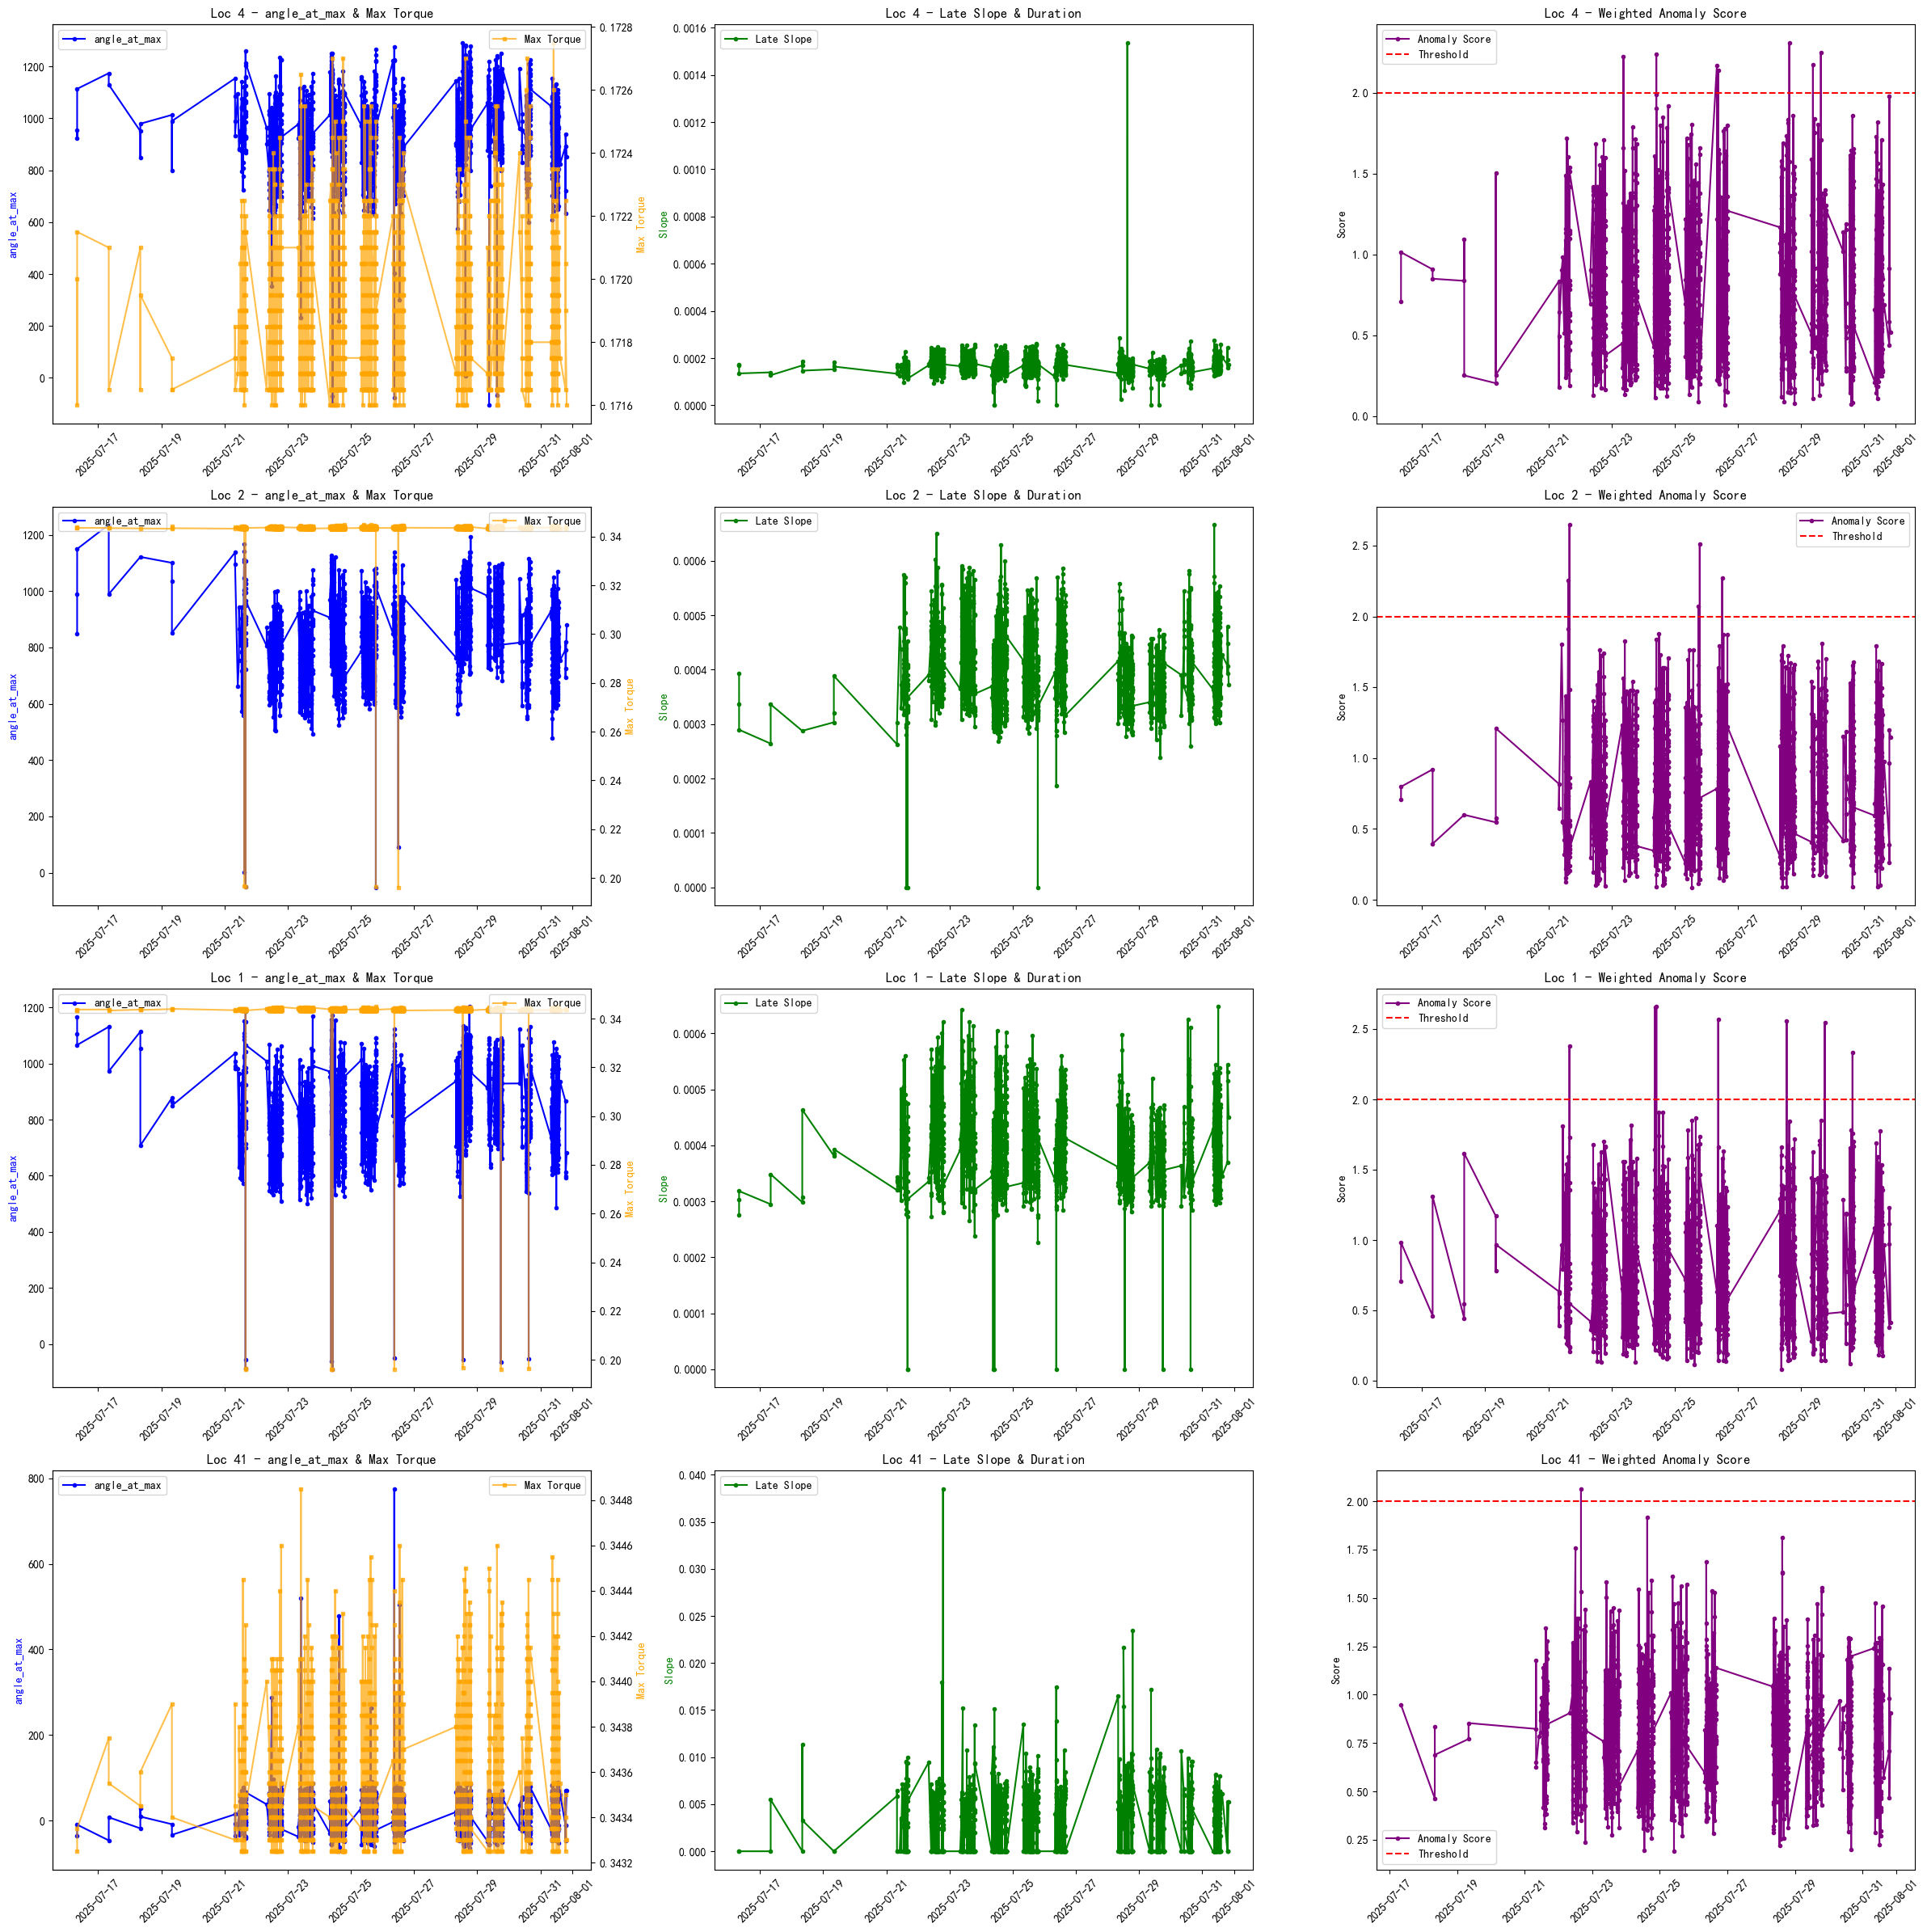

In [99]:
fig, axes = plt.subplots(len(loc_results), 3, figsize=(24, 6 * len(loc_results)), squeeze=False)

for i, (loc, data) in enumerate(loc_results.items()):
    ax1, ax2, ax3 = axes[i]

    # Âõæ1ÔºöAUC + Max Torque
    ax1.plot(data['time'], data['angle_at_max'], 'o-', label='angle_at_max', color='blue', markersize=3)
    ax1_twin = ax1.twinx()
    ax1_twin.plot(data['time'], data['max_torque'], 's-', label='Max Torque', color='orange', alpha=0.7, markersize=3)
    ax1.set_title(f'Loc {loc} - angle_at_max & Max Torque')
    ax1.set_ylabel('angle_at_max', color='blue')
    ax1_twin.set_ylabel('Max Torque', color='orange')
    ax1.legend(loc='upper left')
    ax1_twin.legend(loc='upper right')

    # Âõæ2Ôºö‰∏äÂçáÂêéÂçäÊñúÁéá + Êó∂Èó¥Ë∑®Â∫¶
    ax2.plot(data['time'], data['slope_rise_late'], 'o-', label='Late Slope', color='green', markersize=3)
    ax2.set_title(f'Loc {loc} - Late Slope & Duration')
    ax2.set_ylabel('Slope', color='green')
    ax2.legend(loc='upper left')

    # Âõæ3ÔºöÁªºÂêàÂºÇÂ∏∏ÂæóÂàÜ
    ax3.plot(data['time'], data['anomaly_score'], 'o-', label='Anomaly Score', color='purple', markersize=3)
    ax3.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
    ax3.set_title(f'Loc {loc} - Weighted Anomaly Score')
    ax3.set_ylabel('Score')
    ax3.legend()

# Ë∞ÉÊï¥Â≠êÂõæ‰πãÈó¥ÁöÑÈó¥Ë∑ù
plt.subplots_adjust(wspace=0.3, hspace=0.5)
# ÊóãËΩ¨Ê®™ÂùêÊ†áÊ†áÁ≠æ
for ax in axes.flat:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [100]:
bad_results = []

for i, (loc, data) in enumerate(loc_results.items()):
    bad_results.append(data[(data['recommended_action'] != 'Continue') | (data['suggest_replace'] == True)])

bad_results = pd.concat(bad_results, ignore_index=True)
# , 'auc_z'
bad_results[['hsgsn', 'time', 'recommended_action', 'loc', 'suggest_replace', 'anomaly_score', 'max_torque_z',
       'angle_at_max_z', 'slope_rise_late_z', 'total_angle_z',
       'std_torque_z', 'row_span_z', 'weighted_zsum']]


hsgsn                time recommended_action  loc  \
0   H3HHJ2000CX0000X42 2025-07-22 12:04:01             Rework    4   
1   F9WHHX000AS0000X7S 2025-07-23 09:02:06           Continue    4   
2   H3HHJ7002JM0000X45 2025-07-23 10:04:09             Rework    4   
3   F9WHJ8000VT0000X7T 2025-07-24 10:02:04           Continue    4   
4   H3HHJ4001D70000X43 2025-07-24 13:05:08             Rework    4   
5   F9WHHV001AW0000X7S 2025-07-24 15:04:05             Rework    4   
6   F9W004770940000X7T 2025-07-26 08:02:08           Continue    4   
7   F9WHJ1000NK0000X7U 2025-07-26 09:01:00                 FA    4   
8   F9WHJ2001430000X7U 2025-07-26 09:04:07           Continue    4   
9   H3HHJ30002P0000X42 2025-07-26 13:02:03             Rework    4   
10  F9WHHY000KX0000X7V 2025-07-28 15:03:05           Continue    4   
11  F9WHJN000BF0000X7U 2025-07-29 09:01:05           Continue    4   
12  F9WHJ6000550000X7W 2025-07-29 15:02:09           Continue    4   
13  H3HHJ3000EP0000X7P 2025-07-30 13:04:03             Rework    4   
14  F9WHJA0000W0000X7T 2025-07-21 15:01:08           Continue    2   
15  F9WHJ0000470000X7T 2025-07-21 16:02:01           Continue    2   
16  H3HHJ6000M30000X45 2025-07-23 19:02:09             Rework    2   
17  H3HHJ4000V20000X43 2025-07-24 14:01:07             Rework    2   
18  F9WHJ20014D0000X7U 2025-07-25 18:05:07           Continue    2   
19  F9WHJ30006V0000X7U 2025-07-25 19:00:05           Continue    2   
20  F9WHHK0002E0000X7R 2025-07-26 12:04:07           Continue    2   
21  H3HHJ40004S0000X7P 2025-07-30 14:03:07             Rework    2   
22  F9WHJ3000LA0000X7T 2025-07-21 16:01:09           Continue    1   
23  H3HHJ3000CM0000X42 2025-07-22 13:02:09                 FA    1   
24  F9WHHX0006M0000X7S 2025-07-22 16:00:03             Rework    1   
25  H3HHJ7000J90000X45 2025-07-23 10:05:09                 FA    1   
26  F9WHJ8001190000X7T 2025-07-24 09:04:06           Continue    1   
27  F9WHJ3000DW0000X7T 2025-07-24 10:05:01           Continue    1   
28  F9WHJ2001430000X7U 2025-07-26 09:04:07           Continue    1   
29  F9WHHV0005C0000X7V 2025-07-28 13:04:06           Continue    1   
30  F9WHJ20004S0000X7W 2025-07-29 18:00:08             Rework    1   
31  F9WHJ2000210000X7W 2025-07-29 18:00:09           Continue    1   
32  F9WHJ1000SV0000X7U 2025-07-30 15:05:01           Continue    1   
33  F9WHHW001ZM0000X7S 2025-07-22 16:00:08           Continue   41   

    suggest_replace  anomaly_score  max_torque_z  angle_at_max_z  \
0             False       1.682046      0.606092       -2.629349   
1              True       2.225145     -1.504578       -2.513957   
2             False       1.517775      0.716162       -2.550659   
3              True       2.241046      2.012275       -2.260611   
4             False       1.008498     -0.756787       -0.943941   
5             False       1.847659     -0.743614       -2.573981   
6              True       2.171894      1.137622        2.472426   
7             False       1.527243     -0.324314       -2.462089   
8              True       2.139879      0.516398       -2.697903   
9             False       1.572887     -0.656781       -2.589510   
10             True       2.310689      0.883883       -2.683427   
11             True       2.174366     -0.094816       -2.809514   
12             True       2.250307     -1.017966       -2.710494   
13            False       1.306848      0.201637        1.673501   
14             True       2.252445     -2.846012       -2.300951   
15             True       2.647656     -2.846039       -2.762504   
16            False       0.820830     -0.308697        0.953124   
17            False       0.813594     -1.130988        0.537392   
18             True       2.069029      1.484644       -2.230088   
19             True       2.511647     -2.845983       -2.681168   
20             True       2.269777     -2.846002       -2.634031   
21            False       0.882449     -0.300598        0.747502   
22

### 3.2.2 ÊñπÊ°à‰∫å

Êõ¥‰∏çÈù†Ë∞±ÔºåÂ∫îËØ•ÊòØÁâπÂæÅ‰∏çÂ§üÂáÜÁ°Æ

In [ ]:
from sklearn.ensemble import IsolationForest

loc_groups = final_features['loc'].unique()
feature_cols = ['max_torque', 'angle_at_max', 'auc', 'slope_rise_late', 'total_angle', 'std_torque', 'row_span']
bad_results = []

for loc in loc_groups:
    data = final_features[final_features['loc'] == loc].copy()
    # ÊªëÂä®Á™óÂè£Ê†áÂáÜÂåñ
    for col in feature_cols:
        data[f'{col}_z'] = (data[col] - data[col].rolling(window=window_size, min_periods=1).mean()).abs() / (data_loc[col].rolling(window=window_size, min_periods=1).std() + 1e-6)

    clf = IsolationForest(n_estimators=100, contamination=0.005, random_state=1)
    X = data[[f'{f}_z' for f in feature_cols]].fillna(0)
    # X = data[['max_torque', 'angle_at_max', 'auc', 'slope_rise_late', 'total_angle', 'std_torque', 'row_span']].fillna(0)
    # ËÆ°ÁÆóÂä†ÊùÉÂºÇÂ∏∏ÂàÜÊï∞
    y_pred = clf.fit_predict(X)
    anomaly_scores = -clf.score_samples(X)  # ËΩ¨Êç¢‰∏∫"Ë∂äÂºÇÂ∏∏ÂàÜÊï∞Ë∂äÈ´ò"
    data['anomaly_score'] = anomaly_scores
    data['is_anomaly'] = (y_pred == -1).astype(int)
    bad_results.append(data[(data['recommended_action'] != 'Continue') | (data['is_anomaly'] == 1)])

bad_results = pd.concat(bad_results, ignore_index=True)
bad_results[['hsgsn', 'time', 'recommended_action', 'is_anomaly', 'loc', 'anomaly_score']]

hsgsn                time recommended_action  is_anomaly  \
0   H3HHJ2000CX0000X42 2025-07-22 12:04:01             Rework           1   
1   F9WHHY000190000X7S 2025-07-22 18:02:06           Continue           1   
2   H3HHJ7002JM0000X45 2025-07-23 10:04:09             Rework           1   
3   F9WHHN0005H0000X7T 2025-07-24 09:05:09           Continue           1   
4   H3HHJ4001D70000X43 2025-07-24 13:05:08             Rework           0   
5   F9WHHV001AW0000X7S 2025-07-24 15:04:05             Rework           1   
6   F9WHHV002650000X7S 2025-07-24 15:05:04           Continue           1   
7   F9WHJ1000NK0000X7U 2025-07-26 09:01:00                 FA           0   
8   H3HHJ30002P0000X42 2025-07-26 13:02:03             Rework           1   
9   F9WHJ3000KV0000X7T 2025-07-28 10:05:06           Continue           1   
10  F9WHHY000KX0000X7V 2025-07-28 15:03:05           Continue           1   
11  H3HHJ3000EP0000X7P 2025-07-30 13:04:03             Rework           0   
12  F9WHJ1000HW0000X7U 2025-07-30 15:04:03           Continue           1   
13  H3HHHC001530000X43 2025-07-21 10:05:05           Continue           1   
14  F9WHHN000820000X7T 2025-07-21 15:01:06           Continue           1   
15  F9WHHL000UR0000X7Q 2025-07-23 14:05:01           Continue           1   
16  F9WHHL0015Z0000X7Q 2025-07-23 15:04:00           Continue           1   
17  H3HHJ6000M30000X45 2025-07-23 19:02:09             Rework           0   
18  H3HHJ4000V20000X43 2025-07-24 14:01:07             Rework           0   
19  F9WHHJ002MF0000X7R 2025-07-26 10:03:03           Continue           1   
20  F9WHHK0002E0000X7R 2025-07-26 12:04:07           Continue           1   
21  F9WHHY000WN0000X7V 2025-07-28 12:05:05           Continue           1   
22  H3HHJ3000G30000X7P 2025-07-30 14:01:09           Continue           1   
23  H3HHJ40004S0000X7P 2025-07-30 14:03:07             Rework           0   
24  F9WHHS0004D0000X7S 2025-07-31 09:02:00           Continue           1   
25  F9WHJ2002700000X7S 2025-07-31 13:01:09           Continue           1   
26  F9WHHN000820000X7T 2025-07-21 15:01:06           Continue           1   
27  H3HHJ20008U0000X42 2025-07-22 10:04:05           Continue           1   
28  H3HHJ3000CM0000X42 2025-07-22 13:02:09                 FA           0   
29  F9WHHX0006M0000X7S 2025-07-22 16:00:03             Rework           0   
30  F9WHHY0000V0000X7S 2025-07-22 19:01:01           Continue           1   
31  F9WHHX000AS0000X7S 2025-07-23 09:02:06           Continue           1   
32  H3HHJ7000J90000X45 2025-07-23 10:05:09                 FA           1   
33  F9WHHA000MJ0000X7Q 2025-07-23 15:05:03           Continue           1   
34  F9WHHM0000M0000X7T 2025-07-23 19:03:06           Continue           1   
35  F9WHHA001AU0000X7Q 2025-07-24 12:04:00           Continue           1   
36  F9WHHY000GS0000X7V 2025-07-28 12:05:04           Continue           1   
37  F9WHJ20004S0000X7W 2025-07-29 18:00:08             Rework           0   
38  H3HHJ3000G40000X7P 2025-07-30 13:03:05           Continue           1   
39  H3HHJ2000CX0000X42 2025-07-22 12:04:01           Continue           1   
40  H3HHJ7002JM0000X45 2025-07-23 10:04:09           Continue           1   
41  F9WHHV001AW0000X7S 2025-07-24 15:04:05           Continue           1   
42  H3HHJ40000Y0000X7P 2025-07-25 15:05:05           Continue           1   
43  F9WHJ1000NK0000X7U 2025-07-26 09:01:00           Continue           1   
44  H3HHJ30002P0000X42 2025-07-26 13:02:03           Continue           1   

    loc  anomaly_score  
0     4       0.684597  
1     4       0.684714  
2     4       0.736463  
3     4       0.686334  
4     4       0.597774  
5     4       0.729613  
6     4       0.668648  
7     4       0.632158  
8     4       0.733975  
9     4       0.720446  
10    4       0.794740  
11    4       0.573510  
12    4       0.676855  
13    2       0.668096  
14    2       0.716598  
15    2       0.668806  
16    2       0.671424  
17    2       0.638506  